# Understanding Embeddings Tutorial

This notebook explores how embeddings work and how they capture semantic meaning from text. We'll use different models to generate embeddings and analyze their behavior with various types of text input.

In [1]:
!pip install -q sentence-transformers numpy scikit-learn torch seaborn pandas

import warnings
warnings.filterwarnings('ignore')

from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from typing import List, Tuple, Optional, Dict, Any
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum
from scipy.spatial.distance import cosine, euclidean, cityblock

# Core Embedding Analysis Framework

In [9]:
class DistanceMetric(Enum):
    """Available distance metrics for comparing embeddings."""
    COSINE = 'cosine'
    EUCLIDEAN = 'euclidean'
    MANHATTAN = 'manhattan'

class EmbeddingAnalyzer:
    """A class to analyze and compare text embeddings using various models and metrics."""
    
    AVAILABLE_MODELS = {
        'mpnet': 'all-mpnet-base-v2',  # Good general purpose model
        'minilm': 'all-MiniLM-L6-v2',  # Faster, lighter model
        'multilingual': 'paraphrase-multilingual-mpnet-base-v2',  # For multiple languages
        'distilbert': 'distilbert-base-nli-mean-tokens'  # Balanced performance
    }
    
    def __init__(self, model_name: str = 'mpnet'):
        """Initialize with specified model and use CUDA if available."""
        if model_name not in self.AVAILABLE_MODELS:
            raise ValueError(f"Model must be one of {list(self.AVAILABLE_MODELS.keys())}")
            
        self.model_name = model_name
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = SentenceTransformer(self.AVAILABLE_MODELS[model_name], device=self.device)
    
    def get_embedding(self, text: str) -> np.ndarray:
        """Generate embedding for a single text."""
        return self.model.encode(text, convert_to_numpy=True)
    
    def get_embeddings(self, texts: List[str]) -> np.ndarray:
        """Generate embeddings for multiple texts."""
        return self.model.encode(texts, convert_to_numpy=True)
    
    def compute_similarity(self, text1: str, text2: str, metric: DistanceMetric = DistanceMetric.COSINE) -> float:
        """Compute similarity between two texts using specified metric."""
        emb1 = self.get_embedding(text1).reshape(1, -1)
        emb2 = self.get_embedding(text2).reshape(1, -1)
        
        if metric == DistanceMetric.COSINE:
            return float(cosine_similarity(emb1, emb2)[0][0])
        elif metric == DistanceMetric.EUCLIDEAN:
            return float(1 / (1 + np.linalg.norm(emb1 - emb2)))
        elif metric == DistanceMetric.MANHATTAN:
            return float(1 / (1 + np.sum(np.abs(emb1 - emb2))))
    
    def compare_multiple(self, base_text: str, comparison_texts: List[str], 
                        metric: DistanceMetric = DistanceMetric.COSINE) -> List[Tuple[str, float]]:
        """Compare one text against multiple others using specified metric."""
        base_emb = self.get_embedding(base_text).reshape(1, -1)
        comp_embs = self.get_embeddings(comparison_texts)
        
        similarities = []
        for i, comp_emb in enumerate(comp_embs):
            sim = self.compute_similarity(base_text, comparison_texts[i], metric)
            similarities.append((comparison_texts[i], sim))
            
        return sorted(similarities, key=lambda x: x[1], reverse=True)
    
    def analyze_text_properties(self, text: str) -> dict:
        """Analyze various properties of the text embedding."""
        embedding = self.get_embedding(text)
        return {
            'magnitude': float(np.linalg.norm(embedding)),
            'mean': float(np.mean(embedding)),
            'std': float(np.std(embedding)),
            'min': float(np.min(embedding)),
            'max': float(np.max(embedding)),
            'dimension': embedding.shape[0]
        }

    def plot_similarity_heatmap(self, texts: List[str], metric: DistanceMetric = DistanceMetric.COSINE):
        """Create a heatmap visualization of similarities between all text pairs."""
        n = len(texts)
        similarity_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                similarity_matrix[i, j] = self.compute_similarity(texts[i], texts[j], metric)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(similarity_matrix, annot=True, fmt='.3f', xticklabels=texts, yticklabels=texts)
        plt.title(f'Text Similarity Heatmap ({metric.value})')
        plt.tight_layout()
        plt.show()

    def visualize_embeddings(self, texts: List[str], method: str = 'tsne', perplexity: int = 30):
        """Visualize embeddings using PCA or t-SNE."""
        embeddings = self.get_embeddings(texts)
        
        if method.lower() == 'tsne':
            perplexity = perplexity if perplexity < len(texts) else int(np.sqrt(len(texts)) / 2)
            reducer = TSNE(n_components=2, perplexity=perplexity, random_state=42)
            reduced = reducer.fit_transform(embeddings)
            title = f't-SNE Visualization (perplexity={perplexity})'
        else:
            reducer = PCA(n_components=2, random_state=42)
            reduced = reducer.fit_transform(embeddings)
            explained_var = reducer.explained_variance_ratio_.sum()
            title = f'PCA Visualization (explained variance: {explained_var:.3f})'
        
        plt.figure(figsize=(12, 8))
        plt.scatter(reduced[:, 0], reduced[:, 1])
        
        for i, text in enumerate(texts):
            plt.annotate(text, (reduced[i, 0], reduced[i, 1]))
        
        plt.title(title)
        plt.tight_layout()
        plt.show()

## Basic Examples and Analysis

Let's start with some basic examples to understand how embeddings capture meaning:

# Summary of Findings

### Summary of Numerical Differences:

1. **Cosine vs. Euclidean**: 
   - **Cosine Similarity** ranges from **0 to 1** (or sometimes -1 to 1 if negative values are allowed), where **1** indicates identical directional similarity and **0** means orthogonal (completely dissimilar) directions. In this context, higher values indicate closer angular alignment.
   - **Euclidean Distance** can range from **0** (indicating identical points) to a theoretically **infinite maximum**, depending on the magnitude of embeddings. High Euclidean distance with high cosine similarity means embeddings share direction but differ greatly in scale (magnitude).

2. **Cosine vs. Manhattan**: 
   - **Manhattan Distance** (also known as L1 distance) measures the sum of absolute differences along each dimension. It ranges from **0** (for identical points) to a potentially **infinite maximum**, depending on the dimensional spread.
   - Differences between Cosine and Manhattan distances indicate that embeddings may have similar directions but vary in the spread of values across dimensions. A large Manhattan distance with high cosine similarity suggests spread values in the same general direction.

3. **Euclidean vs. Manhattan**:
   - **Euclidean Distance** captures overall straight-line (L2) distance, whereas Manhattan Distance captures cumulative, grid-like distance.
   - If Euclidean and Manhattan distances are both small, it implies overall and dimensional alignment. Divergence between the two indicates that the dimensional spread differs more substantially than overall similarity.

### Summary Table Usage:
Use the comparison table to observe how similarity and distance metrics vary numerically between each pair of embeddings. This can help identify patterns in both direction (cosine similarity) and magnitude (Euclidean and Manhattan distances).


Example 1: Similar meaning, different words



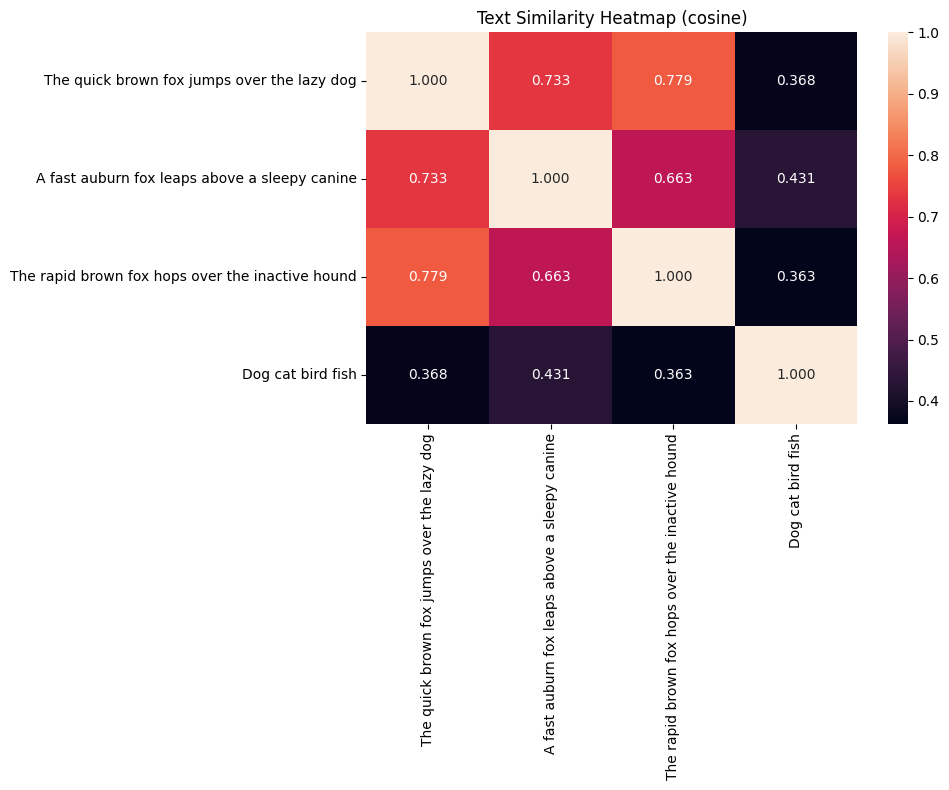

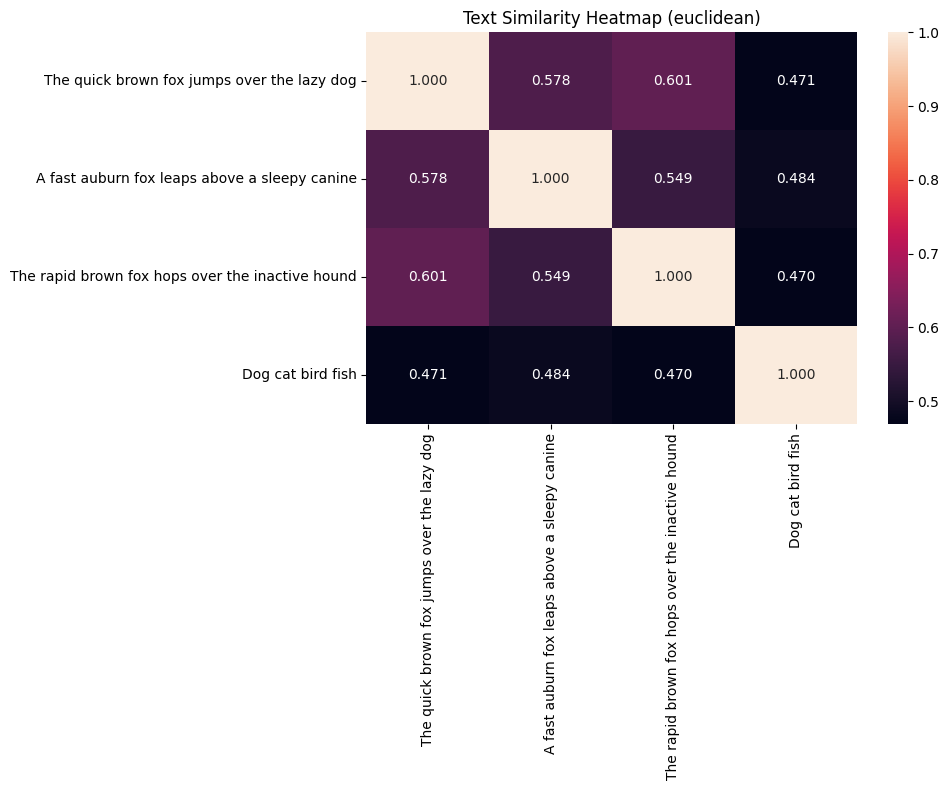

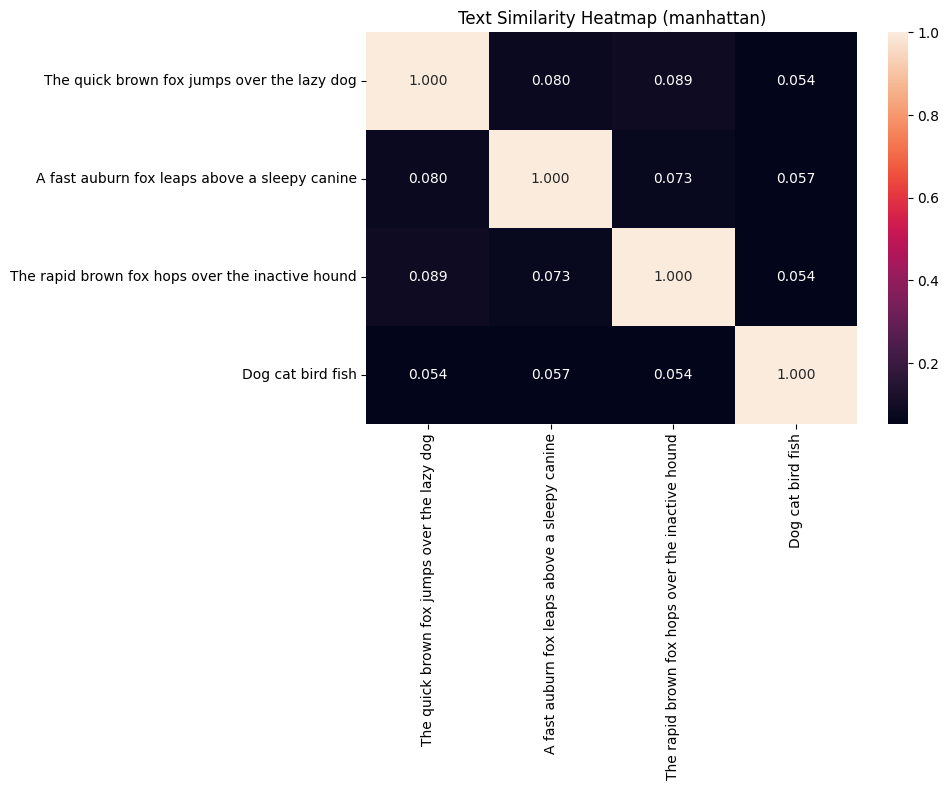

In [ ]:
analyzer = EmbeddingAnalyzer('minilm')

# Example 1: Similar meaning, different words
base = "The quick brown fox jumps over the lazy dog"
comparisons = [
    "A fast auburn fox leaps above a sleepy canine",
    "The rapid brown fox hops over the inactive hound",
    "Dog cat bird fish"
]

print("Example 1: Similar meaning, different words\n")

analyzer.plot_similarity_heatmap([base] + comparisons)  # Defaults to DistanceMetric.COSINE
analyzer.plot_similarity_heatmap([base] + comparisons, metric=DistanceMetric.EUCLIDEAN)
analyzer.plot_similarity_heatmap([base] + comparisons, metric=DistanceMetric.MANHATTAN)


analyzer.visualize_embeddings([base] + comparisons, method='tsne')
analyzer.visualize_embeddings([base] + comparisons, method='pca')

Example 2: Negation Analysis



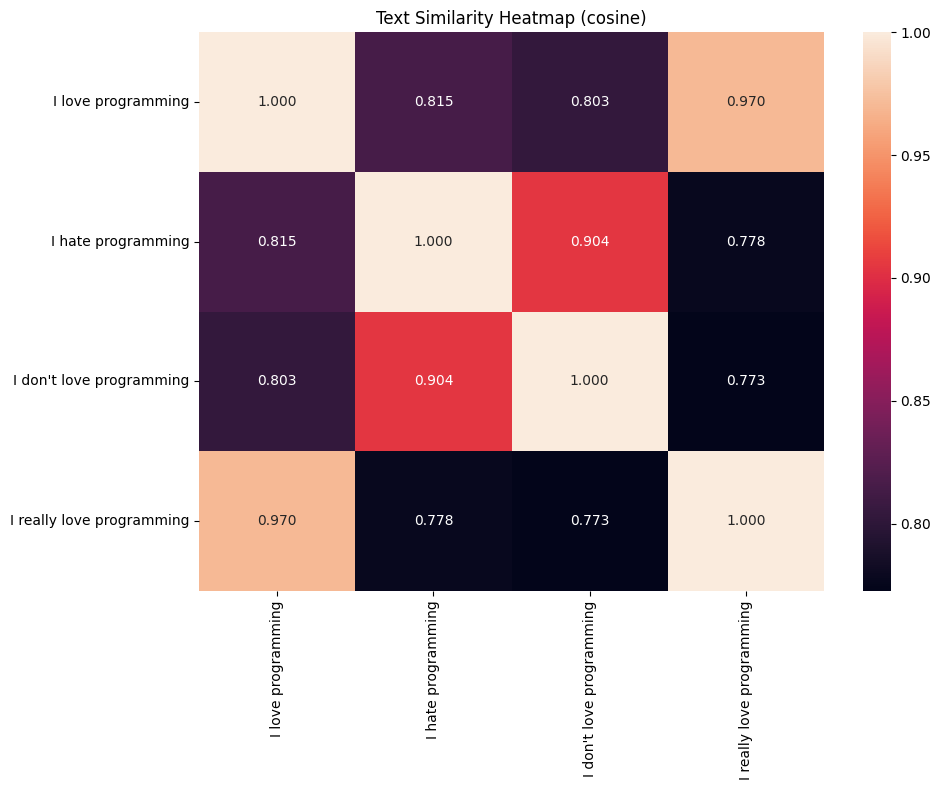

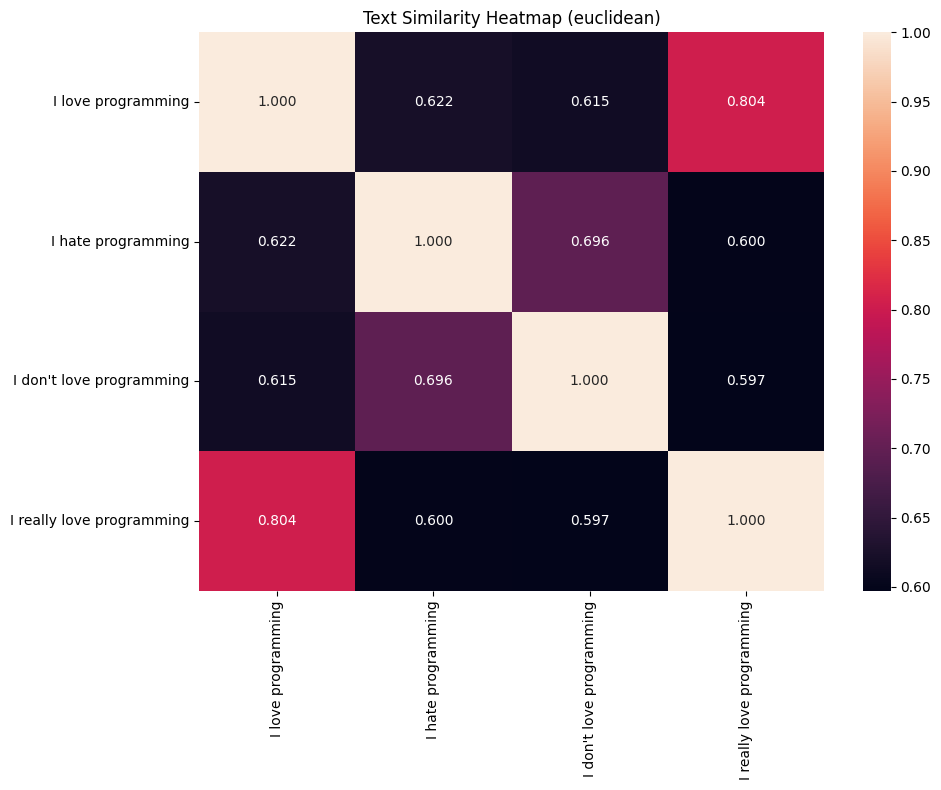

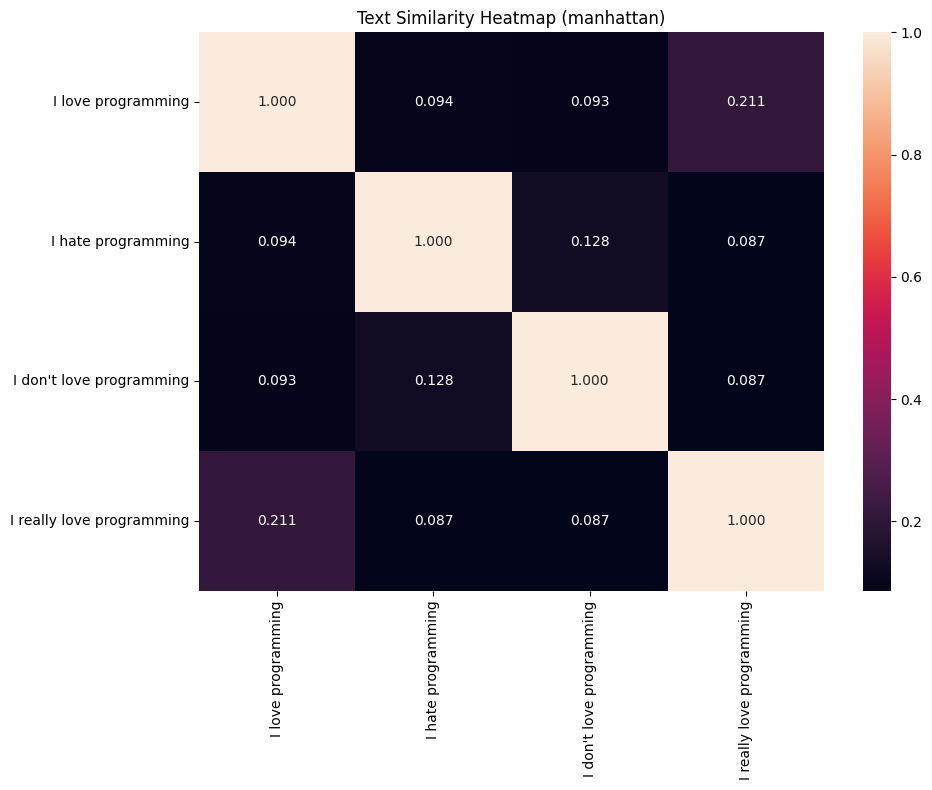

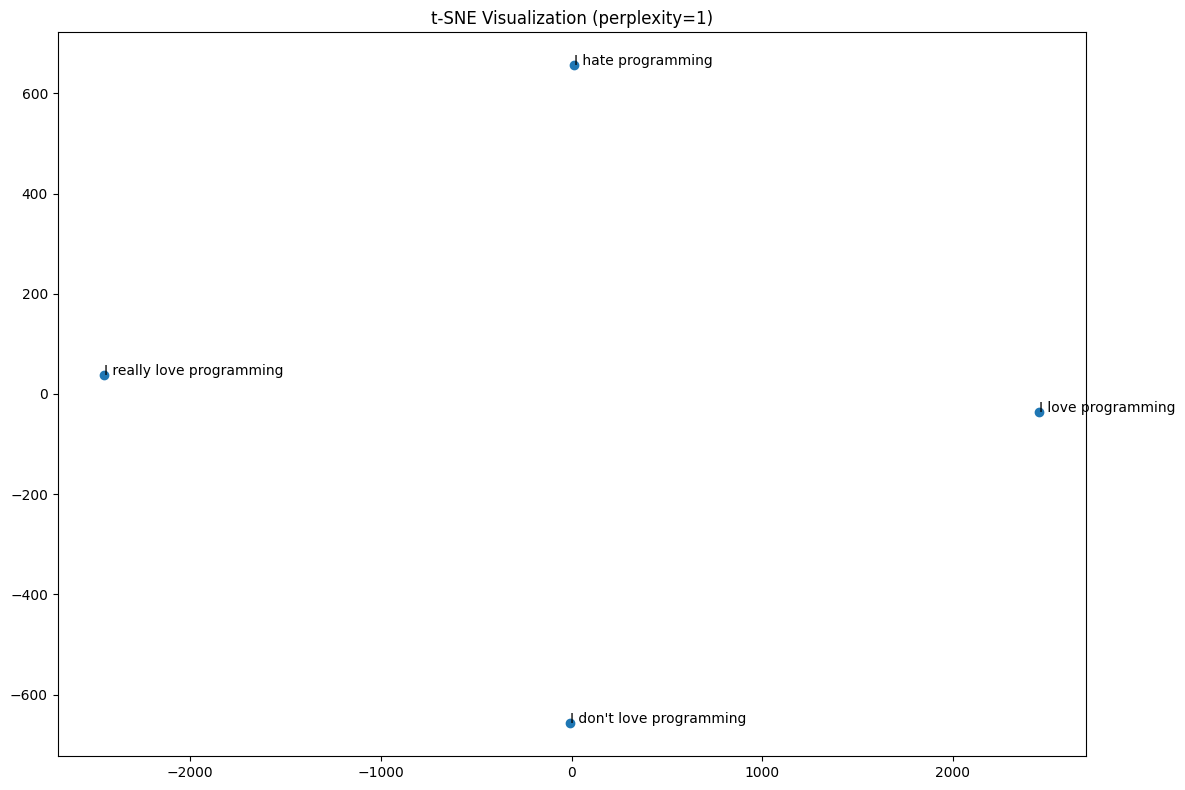

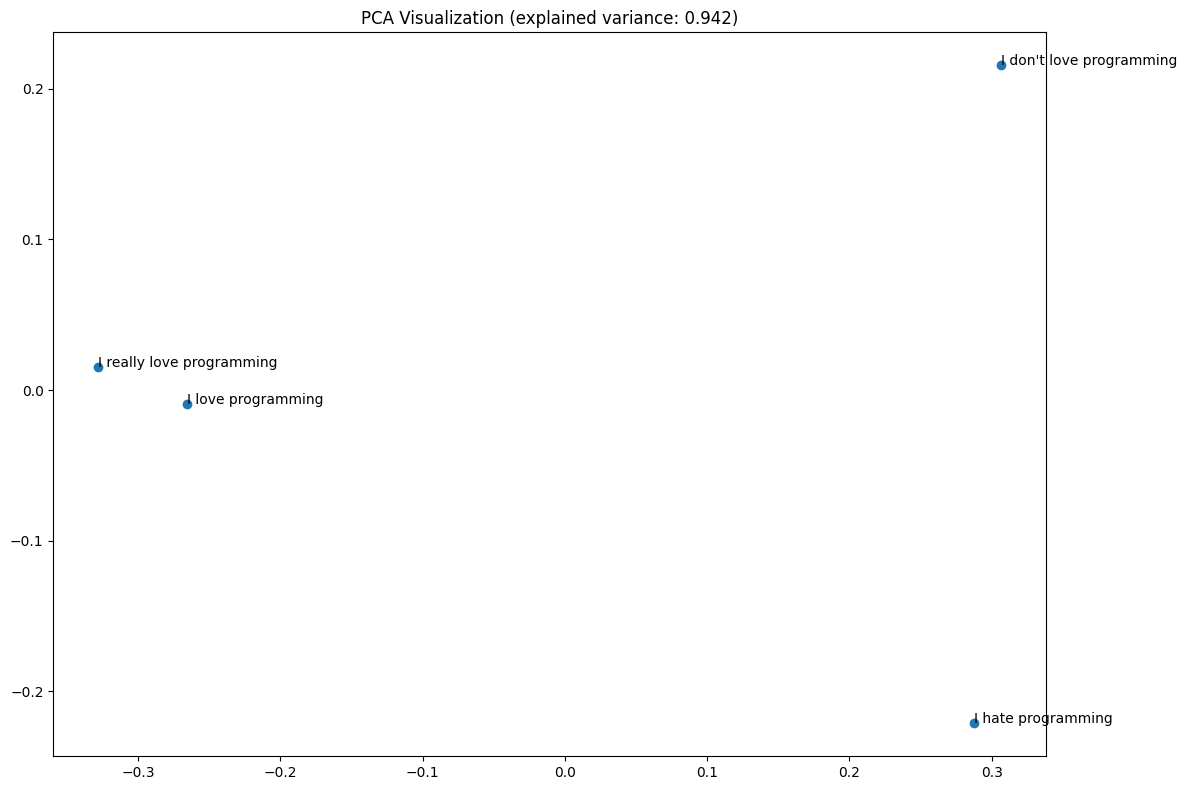

In [14]:
# Example 2: Negation Analysis
base = "I love programming"
comparisons = [
    "I hate programming",
    "I don't love programming",
    "I really love programming"
]

print("Example 2: Negation Analysis\n")
analyzer.plot_similarity_heatmap([base] + comparisons)  # Defaults to DistanceMetric.COSINE
analyzer.plot_similarity_heatmap([base] + comparisons, metric=DistanceMetric.EUCLIDEAN)
analyzer.plot_similarity_heatmap([base] + comparisons, metric=DistanceMetric.MANHATTAN)

analyzer.visualize_embeddings([base] + comparisons, method='tsne')
analyzer.visualize_embeddings([base] + comparisons, method='pca')

## Diverse Text Analysis

Now let's analyze a more diverse set of texts to understand how embeddings handle different types of content:

Analyzing Diverse Texts



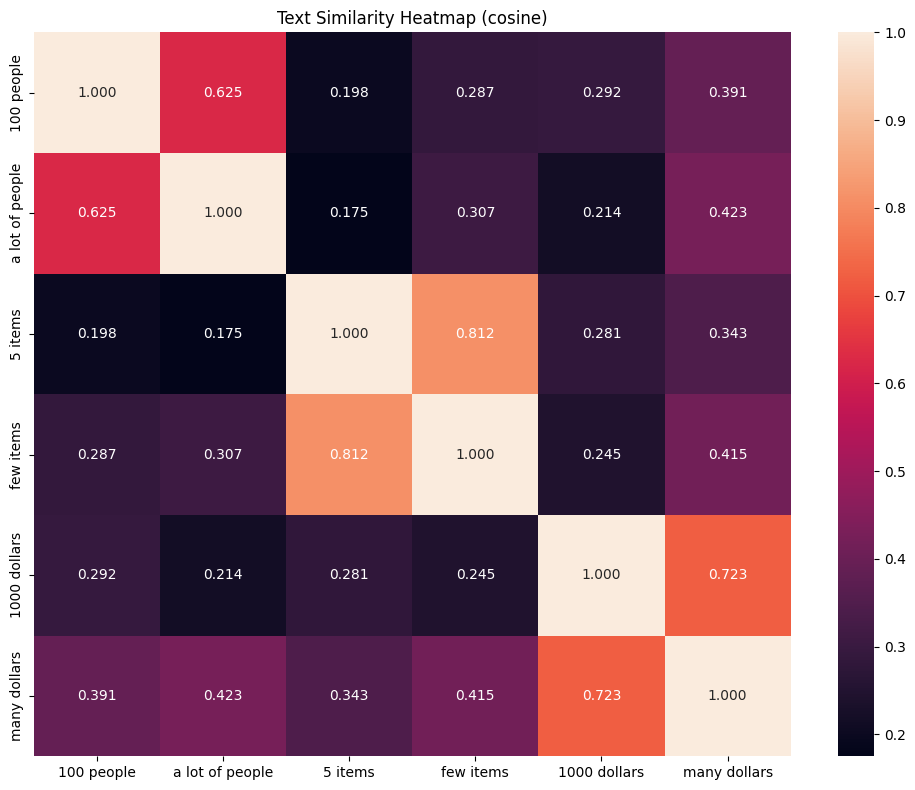

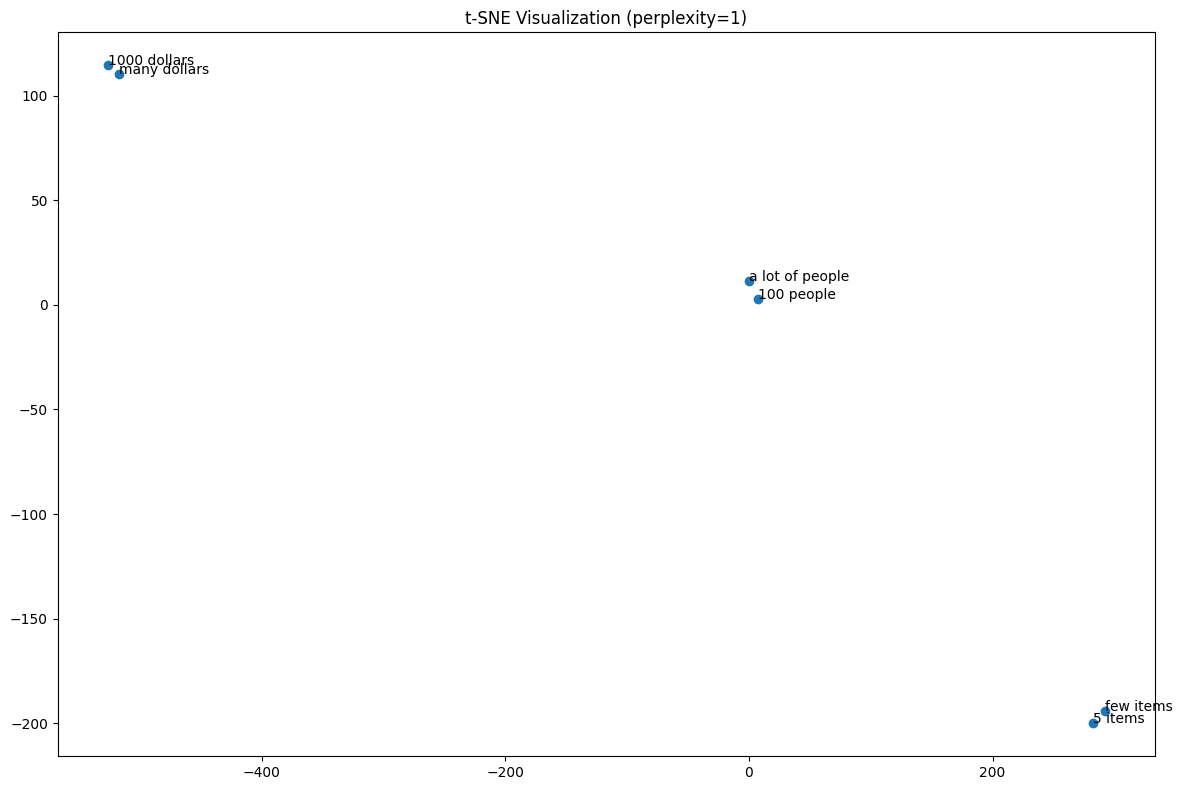

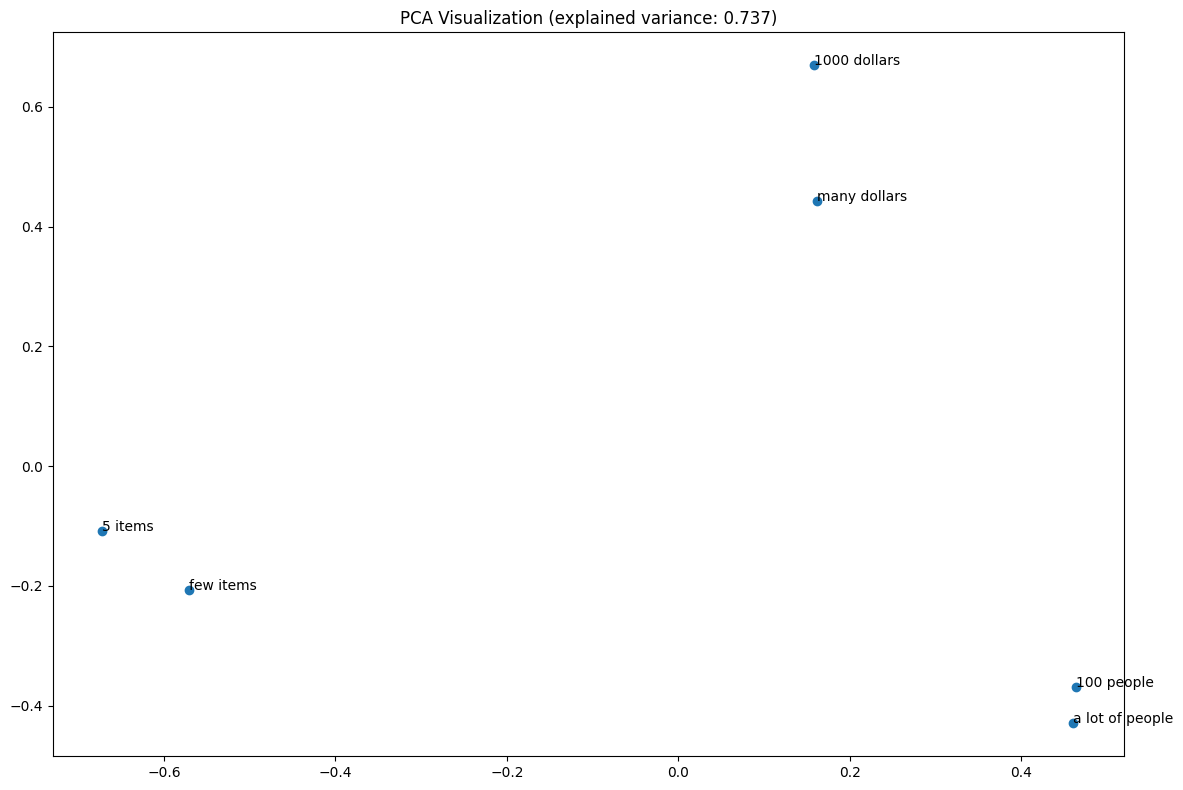

In [16]:
diverse_texts = [
    # Numbers vs Text descriptions
    '100 people',
    'a lot of people',
    '5 items',
    'few items',
    '1000 dollars',
    'many dollars',
    
    # # Repeated characters
    # 'a',
    # 'aa',
    # 'aaaaaa',
    # 'b',
    # 'bbb',
    # 'bbbbbb',
    
    # # Random strings
    # 'xyz123',
    # 'abc789',
    # 'qwerty',
    # '12345',
    
    # # Similar concepts with different representations
    # 'happy',
    # 'joyful',
    # 'ecstatic',
    # 'sad',
    # 'depressed',
    # 'unhappy',
    
    # # Numbers in different formats
    # 'one thousand',
    # '1000',
    # 'thousand',
    # 'many',
    # 'numerous'
]

# Analyze diverse texts
print("Analyzing Diverse Texts\n")
analyzer.plot_similarity_heatmap(diverse_texts)
analyzer.visualize_embeddings(diverse_texts, method='tsne')
analyzer.visualize_embeddings(diverse_texts, method='pca')

## Model Comparison

Let's compare how different models handle the same text pairs:

In [ ]:
def compare_models(text1: str, text2: str):
    """Compare how different models handle the same text pair."""
    results = []
    for model_name in EmbeddingAnalyzer.AVAILABLE_MODELS:
        analyzer = EmbeddingAnalyzer(model_name)
        for metric in DistanceMetric:
            similarity = analyzer.compute_similarity(text1, text2, metric)
            results.append({
                'Model': model_name,
                'Metric': metric.value,
                'Similarity': similarity
            })
    
    df = pd.DataFrame(results)
    print(f"\nComparing: '{text1}' vs '{text2}'")
    print(df.pivot(index='Model', columns='Metric', values='Similarity').round(4))
    return df

# Compare different text pairs across models
text_pairs = [
    ("I love programming", "I enjoy coding"),
    ("The weather is nice", "El clima está bueno"),
    ("This is completely different", "Random text here")
]

for pair in text_pairs:
    compare_models(*pair)

# Summary of Findings

### Summary of Numerical Differences:

1. **Cosine vs. Euclidean**: 
   - **Cosine Similarity** ranges from **0 to 1** (or sometimes -1 to 1 if negative values are allowed), where **1** indicates identical directional similarity and **0** means orthogonal (completely dissimilar) directions.
   - **Euclidean Distance** can range from **0** (indicating identical points) to a theoretically **infinite maximum**, depending on the magnitude of embeddings.

2. **Cosine vs. Manhattan**: 
   - **Manhattan Distance** measures the sum of absolute differences along each dimension.
   - Differences between Cosine and Manhattan distances indicate that embeddings may have similar directions but vary in the spread of values across dimensions.

3. **Visualization Insights**:
   - **t-SNE** is better at preserving local structure and showing clusters of similar texts
   - **PCA** better preserves global structure and shows overall variance in the data

### Key Observations:

1. Similar meanings with different words maintain high similarity scores
2. Negations are captured but with varying degrees of success
3. Different models may interpret the same text pairs differently
4. Numerical representations vs text descriptions show interesting patterns
5. The choice of distance metric can significantly impact similarity measurements